In [209]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [210]:
df = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [211]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [212]:
# ----------------------------------------------
# 1. 결측치 확인 및 처리
# - 수치형 컬럼: 평균값으로 채움 (정보 손실 최소화)
# - 범주형 컬럼: 최빈값으로 채움 (가장 가능성 높은 값으로 대체)
# ----------------------------------------------

print("Before imputation:")

# 스케일링된 불필요한 컬럼 제거
df.drop(columns=[col for col in df.columns if col.startswith('Z_') or col.endswith('_scaled')], inplace=True, errors='ignore')

# Income 결측치 제거
df = df[df["Income"].notnull()]

# 수치형 / 범주형 컬럼 분리
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# 수치형 컬럼: 평균값으로 대체
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

# 범주형 컬럼: 최빈값으로 대체
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])


print("After imputation:")
print(df.isnull().sum())



Before imputation:
After imputation:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Response               0
dtype: int64


In [213]:
# ----------------------------------------------
# 2. 이상치 처리 (IQR 방식)
# - 제거 대신 중앙값으로 대체하여 데이터 손실 방지
# ----------------------------------------------
# 결측치 -> 평균(수치형), 최빈값(범주형)
# 이상치 -> 중앙값
for col in numeric_cols:
    if col == "Response" or col.startswith("AcceptedCmp"):
        continue
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    num_outliers = outlier_mask.sum()

    if num_outliers > 0:
        median = df[col].median()
        df.loc[outlier_mask, col] = median
        print(f"- {col} 이상치 {num_outliers}개 → 중앙값({median})으로 대체")

print("이상치 처리 완료")

- Year_Birth 이상치 3개 → 중앙값(1970.0)으로 대체
- Income 이상치 8개 → 중앙값(51381.5)으로 대체
- MntWines 이상치 35개 → 중앙값(174.5)으로 대체
- MntFruits 이상치 246개 → 중앙값(8.0)으로 대체
- MntMeatProducts 이상치 174개 → 중앙값(68.0)으로 대체
- MntFishProducts 이상치 222개 → 중앙값(12.0)으로 대체
- MntSweetProducts 이상치 246개 → 중앙값(8.0)으로 대체
- MntGoldProds 이상치 205개 → 중앙값(24.5)으로 대체
- NumDealsPurchases 이상치 84개 → 중앙값(2.0)으로 대체
- NumWebPurchases 이상치 3개 → 중앙값(4.0)으로 대체
- NumCatalogPurchases 이상치 23개 → 중앙값(2.0)으로 대체
- NumWebVisitsMonth 이상치 8개 → 중앙값(6.0)으로 대체
- Complain 이상치 21개 → 중앙값(0.0)으로 대체
이상치 처리 완료


C:\Users\USER\AppData\Local\Temp\ipykernel_5660\3793031037.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '174.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outlier_mask, col] = median
C:\Users\USER\AppData\Local\Temp\ipykernel_5660\3793031037.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outlier_mask, col] = median


In [214]:
### 2. Stratified Samlpling
# - Response(0/1)의 클래스 비율 유지
from sklearn.model_selection import train_test_split
df_stratified, _ = train_test_split(df, test_size=0.7, stratify=df["Response"], random_state=42)

# 확인용 출력
print("[Stratified Sampling] Response 분포:")
print(df_stratified['Response'].value_counts(normalize=True)) 
print(f"샘플링된 데이터 크기: {df_stratified.shape}")

print("전체 데이터 Response 분포:")
print(df['Response'].value_counts(normalize=True))


### -----------------------------------------------
### 3. Feature Scaling (선택적 스케일링)
# - 목적: 특정 수치형 feature에 대해 정규화 필요 시 표준화(StandardScaler) 적용
# - Mnt_*, AcceptedCmp*, Response 등은 원본 값 유지해야 하므로 제외
# - 기존 스케일링된 컬럼은 유지하고, '_scaled' 접미사로 저장
### -----------------------------------------------

from sklearn.preprocessing import StandardScaler

# 스케일링 제외 대상
exclude_cols = ['Response'] + [col for col in df.columns if col.startswith('Mnt_')] + \
    [col for col in df.columns if col.startswith('AcceptedCmp')]

# 수치형 feature 중 스케일링할 컬럼만 선택
scaling_targets = [col for col in numeric_cols if col not in exclude_cols]

# StandardScaler 적용 (원본 유지, 새로운 컬럼 생성)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[scaling_targets])
scaled_df = pd.DataFrame(scaled_features, columns=[col + '_scaled' for col in scaling_targets], index=df.index)

# 원본 df에 스케일링된 컬럼 추가
df = pd.concat([df, scaled_df], axis=1)

# 확인용 출력
print("\n[Feature Scaling] 스케일링된 컬럼 예시:")
print(df[[col + '_scaled' for col in scaling_targets[:3]]].head())  # 앞의 3개만 예시로 출력


### -----------------------------------------------
### 4. Income Binning
# - 목적: 소득 분포를 범주형 변수로 변환해 시각화 및 그룹 비교에 활용
# - Equal-width: 간격 고정 / Equal-frequency: 빈도 균등
### -----------------------------------------------

# Binning (Income)
df["Income_eq_width"] = pd.cut(df["Income"], bins=3, labels=["Low", "Medium", "High"])
df["Income_eq_freq"] = pd.qcut(df["Income"], q=3, labels=["Low", "Medium", "High"])

# 확인용 출력
print("\n[Income Binning] 구간별 분포 확인:")
print("Equal Width Binning:\n", df["Income_eq_width"].value_counts())
print("Equal Frequency Binning:\n", df["Income_eq_freq"].value_counts())


[Stratified Sampling] Response 분포:
Response
0    0.849398
1    0.150602
Name: proportion, dtype: float64
샘플링된 데이터 크기: (664, 27)
전체 데이터 Response 분포:
Response
0    0.849729
1    0.150271
Name: proportion, dtype: float64

[Feature Scaling] 스케일링된 컬럼 예시:
   ID_scaled  Year_Birth_scaled  Income_scaled
0  -0.019809          -1.019594       0.314701
1  -1.051009          -1.276230      -0.255849
2  -0.445526          -0.335232       0.966572
3   0.182737           1.290127      -1.208766
4  -0.081373           1.033492       0.322199

[Income Binning] 구간별 분포 확인:
Equal Width Binning:
 Income_eq_width
Medium    1201
Low        708
High       307
Name: count, dtype: int64
Equal Frequency Binning:
 Income_eq_freq
Low       739
High      739
Medium    738
Name: count, dtype: int64


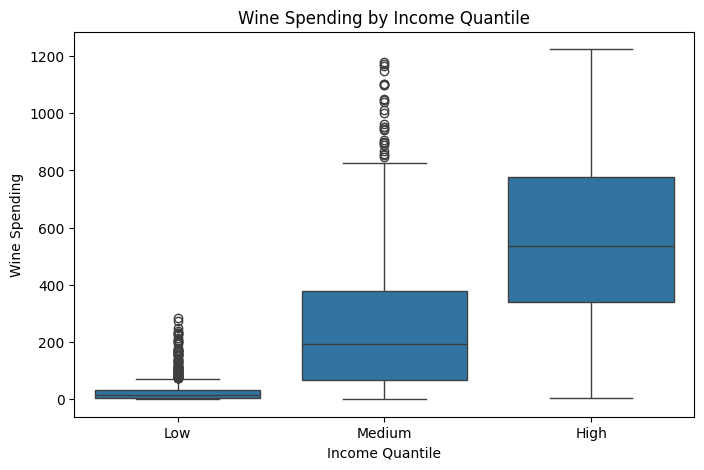

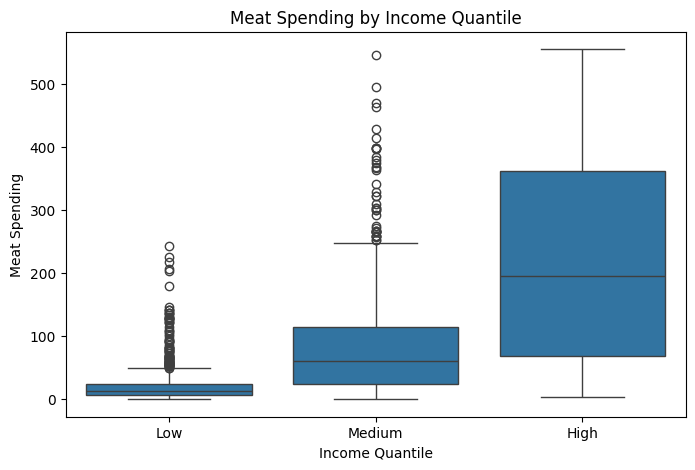

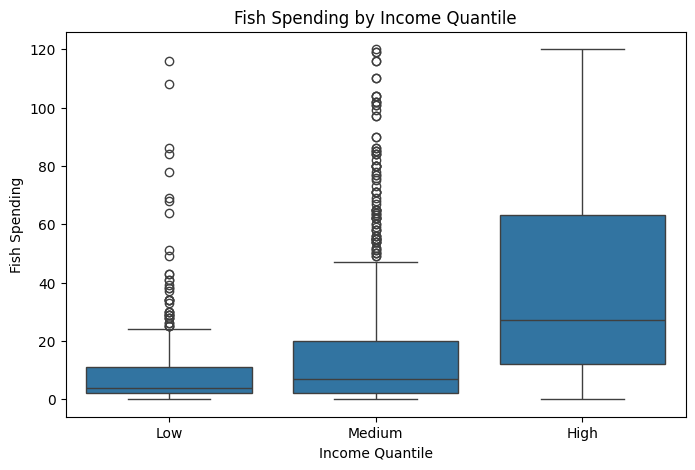

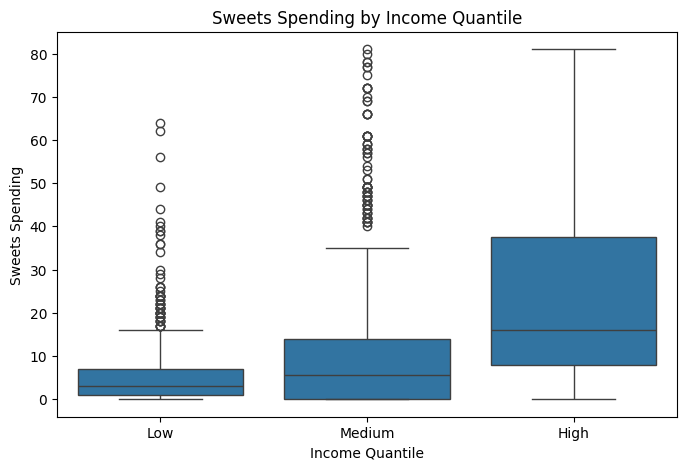

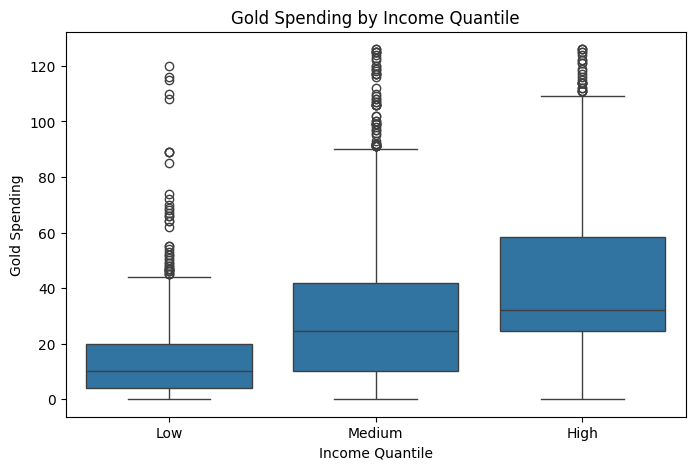

In [215]:
# ----------------------------------------------
# 6. 시각화 : 소득 구간 vs 품목 소비
# - 목적: 소득 구간에 따라 와인, 고기, 생선 등의 소비 패턴을 시각적으로 비교
# ----------------------------------------------
product_cols = [
    ("MntWines", "Wine"), # 와인
    ("MntMeatProducts", "Meat"), # 육류
    ("MntFishProducts", "Fish"), # 웰빙
    ("MntSweetProducts", "Sweets"), # 디저트
    ("MntGoldProds", "Gold") # 금
]

for col, label in product_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Income_eq_freq", y=col, data=df)
    plt.title(f"{label} Spending by Income Quantile")
    plt.xlabel("Income Quantile")
    plt.ylabel(f"{label} Spending")
    plt.show()


In [216]:
# 이상치 제거
## 생년 이상치 제거
df = df[(df["Year_Birth"] >= 1900) & (df["Year_Birth"] <= 2005)]


In [217]:
# ----------------------------------------------
#  파생 변수 생성: Customer 가입 연/월
# - 목적: 가입 시점(연/월)을 기반으로 고객 분석/그룹화 가능하도록 처리
# ----------------------------------------------
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)
df["Customer_Year"] = df["Dt_Customer"].dt.year
df["Customer_Month"] = df["Dt_Customer"].dt.month
df.drop(columns=["Dt_Customer"], inplace=True)

In [218]:
# ----------------------------------------------
# 7. 원-핫 인코딩 (필요한 경우에만)
# - 목적: 범주형 변수들을 모델링 및 분석 가능하도록 수치화
# - drop_first=True로 다중공선성 방지
# ----------------------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

# ----------------------------------------------
# 8. 스케일링 처리 (선택적)
# - 목적: 일부 수치형 변수 정규화
# - Response, Mnt_*, AcceptedCmp*는 예측 타깃 및 구매 금액 관련 변수로 원본 유지
# - 기존에 생성된 *_scaled 컬럼은 중복 방지를 위해 제거
# ----------------------------------------------
exclude_cols = ['Response'] + [col for col in df_encoded.columns if col.startswith('Mnt')] + [col for col in df_encoded.columns if col.startswith('AcceptedCmp')]

scaling_targets = [col for col in df_encoded.select_dtypes(include=["number"]).columns if col not in exclude_cols]

scaler = StandardScaler()
df_encoded = df_encoded.loc[:, ~df_encoded.columns.str.endswith('_scaled')]  # 기존 스케일된 컬럼 제거


In [219]:
# 결과 저장 및 확인
df_encoded.to_csv("../data/cleaned_marketing_campaign.csv", index=False)
df_encoded

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Income_eq_width_Medium,Income_eq_width_High,Income_eq_freq_Medium,Income_eq_freq_High
0,5524,1957,58138.0,0,0,58,635.0,8,546,12,...,False,False,True,False,False,False,True,False,True,False
1,2174,1954,46344.0,1,1,38,11.0,1,6,2,...,False,False,True,False,False,False,True,False,True,False
2,4141,1965,71613.0,0,0,26,426.0,49,127,111,...,False,False,False,True,False,False,True,False,False,True
3,6182,1984,26646.0,1,0,26,11.0,4,20,10,...,False,False,False,True,False,False,False,False,False,False
4,5324,1981,58293.0,1,0,94,173.0,43,118,46,...,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,61223.0,0,1,46,709.0,43,182,42,...,False,True,False,False,False,False,True,False,True,False
2236,4001,1946,64014.0,2,1,56,406.0,0,30,0,...,False,False,False,True,False,False,True,False,False,True
2237,7270,1981,56981.0,0,0,91,908.0,48,217,32,...,True,False,False,False,False,False,True,False,True,False
2238,8235,1956,69245.0,0,1,8,428.0,30,214,80,...,False,False,False,True,False,False,True,False,False,True


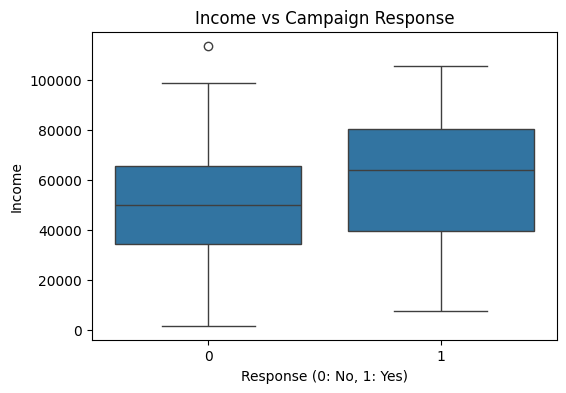

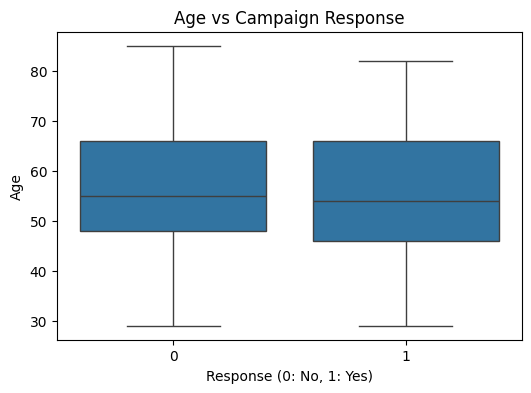

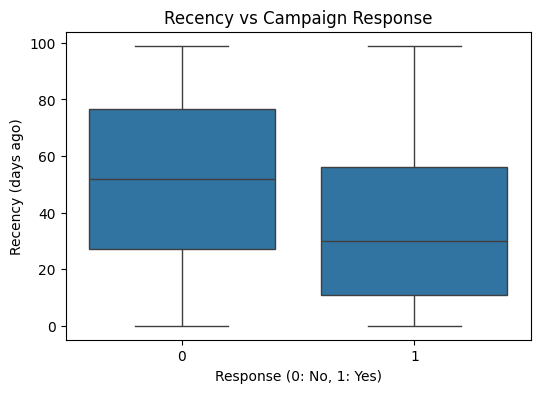

In [220]:
# ----------------------------------------------
# 9. 시각화: Response vs Income/Age/Recency
# - 목적: 구매 반응(Response)에 영향을 주는 주요 변수 탐색
# - 결론: 높은 수입, 어린 연령, 최근 방문자가 긍정적 반응 경향
# ----------------------------------------------

# 9-1. 소득에 따른 구매 반응
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Income", data=df)
plt.title("Income vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Income")
plt.show()

# 9-2. 나이에 따른 구매 반응
df["Age"] = 2025 - df["Year_Birth"]
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Age", data=df)
plt.title("Age vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Age")
plt.show()

# 9-3. Recency (최근 구매일) vs 반응
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Recency", data=df)
plt.title("Recency vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Recency (days ago)")
plt.show()

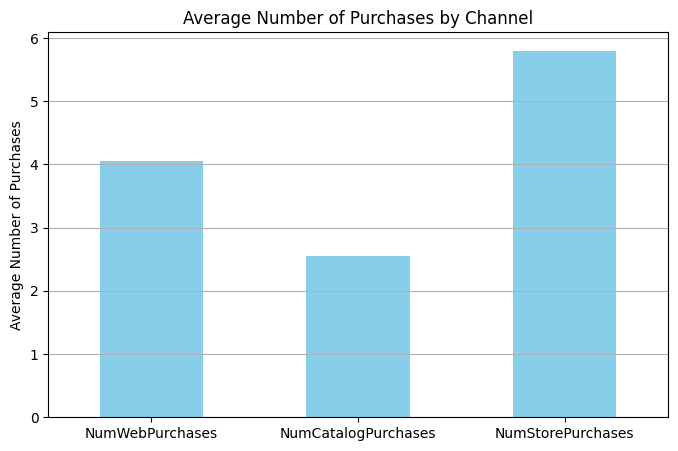

In [221]:
# ----------------------------------------------
# 10. 시각화 : 채널별 평균 구매 수
# - 목적: 각 구매 채널에서 평균적으로 몇 번 구매가 이루어지는지 비교
# ----------------------------------------------

channel_cols = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]

plt.figure(figsize=(8, 5))
df[channel_cols].mean().plot(kind='bar', color='skyblue')
plt.title("Average Number of Purchases by Channel")
plt.ylabel("Average Number of Purchases")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


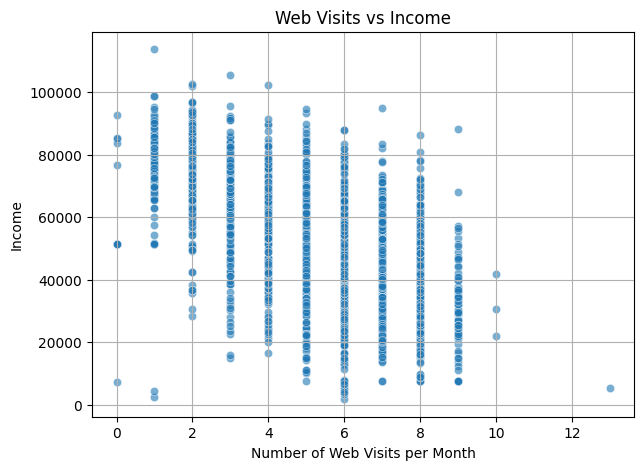

In [222]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="NumWebVisitsMonth", y="Income", data=df, alpha=0.6)
plt.title("Web Visits vs Income")
plt.xlabel("Number of Web Visits per Month")
plt.ylabel("Income")
plt.grid(True)
plt.show()


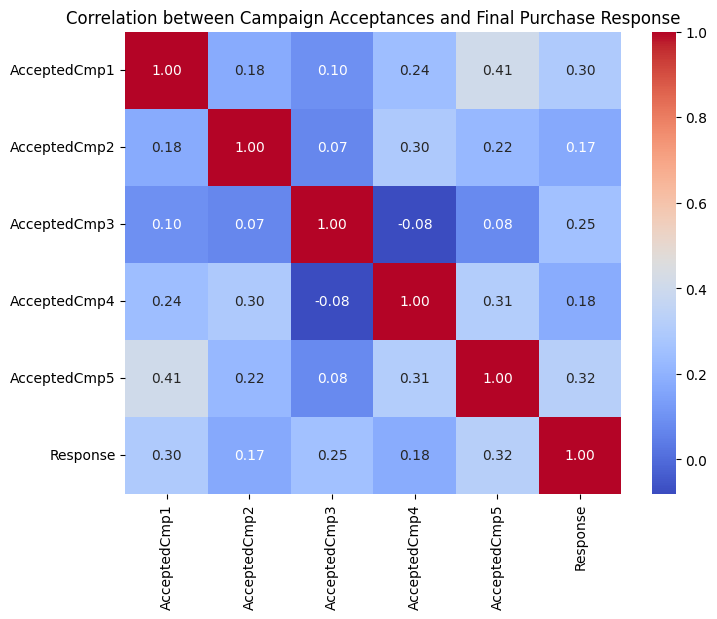

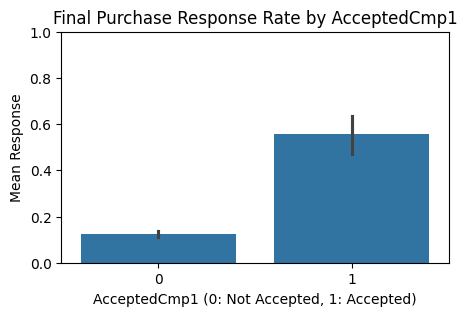

AcceptedCmp1 value counts:
AcceptedCmp1
0    2074
1     142
Name: count, dtype: int64



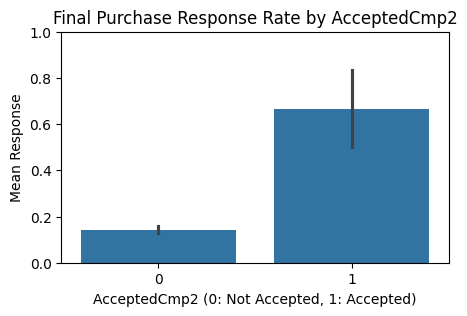

AcceptedCmp2 value counts:
AcceptedCmp2
0    2186
1      30
Name: count, dtype: int64



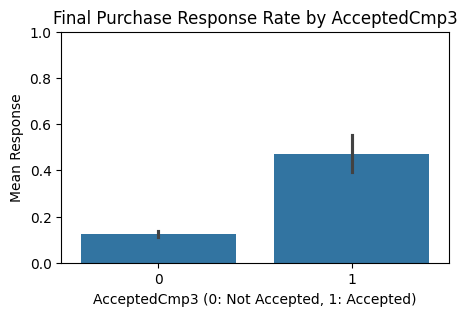

AcceptedCmp3 value counts:
AcceptedCmp3
0    2053
1     163
Name: count, dtype: int64



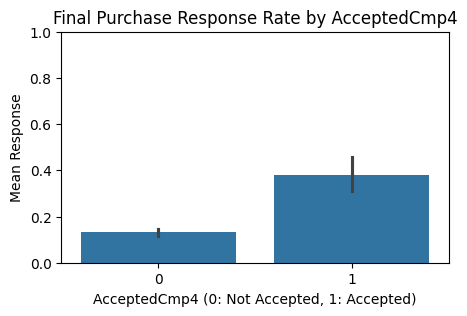

AcceptedCmp4 value counts:
AcceptedCmp4
0    2052
1     164
Name: count, dtype: int64



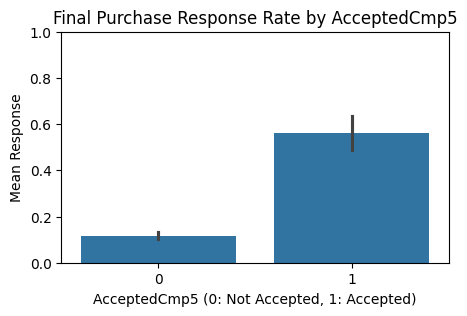

AcceptedCmp5 value counts:
AcceptedCmp5
0    2054
1     162
Name: count, dtype: int64



In [223]:
# ----------------------------------------------
# 11. 캠페인 반응과 최종 구매 반응(Response)의 관계 분석
# - AcceptedCmp1~5 캠페인 수락 여부와 최종 구매 반응 간의 연관성 파악
# - 해당 변수들이 Response 예측에 유의미한 feature인지 확인
# - 방법:
#   (1) 상관계수 히트맵으로 전체 연관성 확인
#   (2) 각 캠페인 수락 여부에 따른 평균 Response 시각화
# ----------------------------------------------

# 1. 캠페인 관련 컬럼 리스트
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# 2. 상관계수 히트맵
# - 목적: 캠페인 수락 변수들과 최종 Response 간의 선형 관계 파악
# -> 어떤 캠페인이 최종 반응과 높은 상관이 있는지 한눈에 파악 가능
plt.figure(figsize=(8, 6))
corr_matrix = df[cmp_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Campaign Acceptances and Final Purchase Response")
plt.show()

# 3. Response 평균 비교 막대그래프
# - 각 캠페인(1~5)을 수락했을 때의 Response 평균과 수락하지 않았을 때의 평균 비교
# - 해석 방법:
#   - Response 평균은 구매 전환율(0~1 사이 값)
#   - 1 수락자에서 평균이 확연히 높으면 유의미한 변수
# - 추가 출력: 각 캠페인 변수의 값 분포 (value_counts) → 데이터 불균형 확인
for col in cmp_cols[:-1]:  # Response 제외
    plt.figure(figsize=(5, 3))
    sns.barplot(x=col, y='Response', data=df)
    plt.title(f"Final Purchase Response Rate by {col}")
    plt.xlabel(f"{col} (0: Not Accepted, 1: Accepted)")
    plt.ylabel("Mean Response")
    plt.ylim(0, 1)
    plt.show()
    print(f"{col} value counts:\n{df[col].value_counts()}\n")